<a href="https://colab.research.google.com/github/GaohRyan/cornell-cs4756-2026sp/blob/master/assignments/A1/programming/CS4756_A1_Programming_Release.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Due Date**
2/19/2026 at 11:59PM EST

# **Introduction**

Welcome to Assignment 1 of CS 4756/5756. In this assignment, you will train an agent using demonstrations from an expert. Concretely, you will:
* Implement behavior cloning (BC)
* **CS 5756 Only:** Implement dataset aggregation (DAgger)

You will use the Fetch agent for this assignment (Reach task), which is part of Gymasium Robotics' Mujoco Environments. Refer to the Gym website for more details about the [Fetch Reach environment](https://robotics.farama.org/envs/fetch/reach/).


Please read through the following paragraphs carefully, as they will apply to this and all future assignments.

**Getting Started: This assignment should be completed in [Google Colab](https://colab.research.google.com/).**

**Evaluation:**
Your code will be tested for correctness and, for certain assignments, speed. For this particular assignment, performance results will not be harshly graded (although we provide approximate expected reward numbers as lower bounds, you are not expected to replicate them exactly); however, it will be important to make an effort to justify your approach which led to the obtained results. Please remember that all assignments should be completed individually.

**Academic Integrity:** We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else’s code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don’t try. We trust you all to submit your own work only; please don’t let us down. If you do, we will pursue the strongest consequences available to us.

**Getting Help:** The [Resources](https://www.cs.cornell.edu/courses/cs4756/2026sp/#resources) section on the course website is your friend! If you ever feel stuck in these projects, please feel free to avail yourself to office hours and Edstem! If you are unable to make any of the office hours listed, please let TAs know and we will be happy to assist. If you need a refresher for PyTorch, please see this [60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)! For Numpy, please see the quickstart [here](https://numpy.org/doc/stable/user/quickstart.html) and full API [here](https://numpy.org/doc/stable/reference/).


# Installation and Setup

In [2]:
import os, torch
if not torch.cuda.is_available():
    os.environ['MUJOCO_GL'] = 'osmesa'
    !apt-get install -y libosmesa6-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libosmesa6-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [3]:
!pip install "cython<3"
!git clone https://github.com/Farama-Foundation/Gymnasium-Robotics.git
!pip install -e Gymnasium-Robotics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12
Cloning into 'Gymnasium-Robotics'...
remote: Enumerating objects: 8196, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 8196 (delta 28), reused 19 (delta 18), pack-reused 8143 (from 2)
Receiving objects: 100% (8196/8196), 402.59 MiB | 32.50 MiB/s, done.
Resolving deltas: 100% (4369/4369), done.
Updating files: 100% (390/390), done.
Obtaining file:///content/Gymnasium-Robotics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
#Include this at the top of your colab code
import os
!rm .mujoco_setup_complete
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !rm -rf ~/.mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc
  # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco-py<2.2,>=2.1'
  # run once
  !touch .mujoco_setup_complete


try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  import mujoco_py
  _mujoco_run_once = True

rm: cannot remove '.mujoco_setup_complete': No such file or directory
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libegl-dev:amd64.
(Reading database ... 118091 files and directories currently installed.)
Preparing to unpack .../00-libegl-dev_1.4.0-1_amd64.deb ...
Unpacking libegl-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libgles1:amd64.
Preparing to unpack .../01-libgles1_1.4.0-1_amd64.deb ...
Unpacking libgles1:amd64 (1.4.0-1) ...
Selecting previously unselected package libgles-dev:amd64.
Preparing to unpack .../02-libgles-dev_1.4.0-1_amd64.deb ...
Unpacking libgles-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libglvnd-core-dev:amd64.
Preparing to unpack .../03-libglvnd-core-dev_1.4.0-1_amd64.deb ...
Unpacking libglvnd-core-dev:amd64 (1.4.0-1) ...
Selecting prev

INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.12/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_312_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-312/usr/local/lib/python3.12/dist-packages/mujoco_py
INFO:root:creating /usr/local/lib/python3.12/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_312_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-312/usr/local/lib/python3.12/dist-packages/mujoco_py/gl
INFO:root:x86_64-linux-gnu-gcc -fno-strict-overflow -Wsign-compare -DNDEBUG -g -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.12/dist-packages/mujoco_py -I/root/.mujoco/mujoco210/include -I/usr/local/lib/python3.12/dist-packages/numpy/_core/include -I/usr/include/python3.12 -c /usr/local/lib/python3.12/dist-packages/mujoco_py/cymj.c -o /usr/local/lib/python3.12/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_312_linuxcpuextensionbuilder/t

In [5]:
import torch
if torch.cuda.is_available():
    print("GPU is available")
    !pip install mujoco

    # Set up GPU rendering.
    from google.colab import files
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    # Check if installation was succesful.
    try:
        print('Checking that the installation succeeded:')
        import mujoco
        mujoco.MjModel.from_xml_string('<mujoco/>')
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')

    print('Installation successful.')

    # Other imports and helper functions
    import time
    import itertools
    import numpy as np

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy
    import mediapy as media
    import matplotlib.pyplot as plt

    # More legible printing from numpy.
    np.set_printoptions(precision=3, suppress=True, linewidth=100)

    from IPython.display import clear_output
    clear_output()

In [6]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install renderlab

In [7]:
import sys
sys.path.append('/content/Gymnasium-Robotics')
import gymnasium as gym
import gymnasium_robotics
import renderlab as rl

ROBOT_PROPRIOCEPTION_KEY = 'observation'
ROBOT_XYZ_GOAL_KEY = 'desired_goal'

USING_COLAB = 'google.colab' in sys.modules

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



### **Downloading Expert File**


In [8]:
!wget https://github.com/kuanfang/cornell-cs4756-2026sp/raw/master/assignments/A1/programming/expert.pt

--2026-02-23 04:17:34--  https://github.com/kuanfang/cornell-cs4756-2026sp/raw/master/assignments/A1/programming/expert.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kuanfang/cornell-cs4756-2026sp/master/assignments/A1/programming/expert.pt [following]
--2026-02-23 04:17:34--  https://raw.githubusercontent.com/kuanfang/cornell-cs4756-2026sp/master/assignments/A1/programming/expert.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 546495 (534K) [application/octet-stream]
Saving to: ‘expert.pt’

expert.pt           100%[===================>] 533.69K  --.-KB/s    in 0.01s   

2026-02-23 04:17

# **Environment and Expert Setup**
The environment is held in ```env``` and the expert agent is held in ```actor_network```.






In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def process_inputs(o, g, o_mean, o_std, g_mean, g_std, clip_obs, clip_range):
    o_clip = np.clip(o, -clip_obs, clip_obs)
    g_clip = np.clip(g, -clip_obs, clip_obs)
    o_norm = np.clip((o_clip - o_mean) / (o_std), -clip_range, clip_range)
    g_norm = np.clip((g_clip - g_mean) / (g_std), -clip_range, clip_range)
    inputs = np.concatenate([o_norm, g_norm])
    inputs = torch.tensor(inputs, dtype=torch.float32)
    return inputs


# define the Expert network
class Expert(nn.Module):
    def __init__(self, env_params, o_mean, o_std, g_mean, g_std):
        super(Expert, self).__init__()
        self.max_action = env_params['action_max']
        self.fc1 = nn.Linear(env_params[ROBOT_PROPRIOCEPTION_KEY] + env_params[ROBOT_XYZ_GOAL_KEY], 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.action_out = nn.Linear(256, env_params['action'])
        self.o_mean = o_mean
        self.o_std = o_std
        self.g_mean = g_mean
        self.g_std = g_std
        self.clip_obs = 200
        self.clip_range = 5

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        actions = self.max_action * torch.tanh(self.action_out(x))

        return actions

    def get_expert_action(self, prop, g):
        inputs = process_inputs(prop, g, self.o_mean, self.o_std, self.g_mean, self.g_std, self.clip_obs, self.clip_range).to(device)
        pi = self.forward(inputs)
        action = pi.detach().cpu().numpy().squeeze()
        return action



## **Notes about Fetch Reach Environment**
The environment uses a Fetch Robot, which is a 7-DoF Mobile Manipulator.

The task is a *goal-reaching task*:
The observation space is a dictionary which contains the robot's proprioception (under the key `ROBOT_PROPRIOCEPTION_KEY`), and the xyz coordinate that the robot's gripper aims to reach (under the key `ROBOT_XYZ_GOAL_KEY`).

All agents have functions defined which take the two pieces of data in order to predict an action to take.

See https://robotics.farama.org/envs/fetch/reach/ for more details.

If the goal is reached, `info['is_success']` will be set to 1, and this is an indication that we should terminate the rollout.

The reward (used only for evaluation in this assignment) is -1 per timestep spent in the environment without completing the task, with 50 steps being the limit (so -50 is the worst episode return).

In [10]:
print(device)
model_path = "expert.pt"
o_mean, o_std, g_mean, g_std, model = torch.load(model_path, map_location=lambda storage, loc: storage, weights_only=False)
model
# create the environment
env = gym.make('FetchReach-v4', render_mode='rgb_array')# get the env param
observation, _ = env.reset()
# get the environment params
env_params = {ROBOT_PROPRIOCEPTION_KEY: observation[ROBOT_PROPRIOCEPTION_KEY].shape[0],
                ROBOT_XYZ_GOAL_KEY: observation[ROBOT_XYZ_GOAL_KEY].shape[0],
                'action': env.action_space.shape[0],
                'action_max': env.action_space.high[0],
                }
# create the Expert network
expert_network = Expert(env_params, o_mean, o_std, g_mean, g_std)
expert_network.to(device)
expert_network.load_state_dict(model)
expert_network.eval()

cpu


Expert(
  (fc1): Linear(in_features=13, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (action_out): Linear(in_features=256, out_features=4, bias=True)
)

In [11]:
# import mujoco_py
import torch.nn as nn
import torch
import numpy as np
import random
import tqdm
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import optimizer
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [12]:
# Setting the seed to ensure reproducability
def reseed(seed):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

reseed(42)

# **Example Demonstration Rollouts**
### **Run an agent in the Fetch Reach environment**

We have provided functions to visualize the environment and compute rewards on the Fetch Reach environment with random actions or expert actions. Looking through this code will help you get familiarized with the environment, and set you up for the next parts in this assignment.

In [13]:
def visualize(env: gym.Env, algorithm=None, video_name="test", stop_at_success=False):
    """
        Visualize a policy network for a given algorithm on a single episode

        Args:
            - env_name: Name of the gym environment to roll out `algorithm` in,
                it will be instantiated using gym.make or make_vec_env.
            - algorithm (PPOActor): Algorithm whose policy network will be rolled
                out for the episode. If no algorithm is passed in, a random policy
                will be visualized.
            - video_name (str): Name for the mp4 file of the episode that will be
                saved (omit .mp4). Only used when running on local machine.
    """


    def get_action(obs):
        if not algorithm:
            return env.action_space.sample()
        else:
            return algorithm.select_action(obs)

    total_reward = 0

    import renderlab as rl

    directory = './video'
    env = rl.RenderFrame(env, "output/")
    obs, info = env.reset()

    for i in range(500):
        action = get_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if stop_at_success and (terminated or truncated or info['is_success']):
            print("breaking")
            break

    if stop_at_success:
        # extend the video because the video library doesn't like short videos
        for i in range(500-i):
            env.step(np.zeros_like(get_action(obs)))

    env.play()

### **Visualize an actor making random actions**
(Approximate expected reward for total reward using random actions: -40 to -50)

Tip: You can run the visualize() blocks multiple times to see the robot acting with different goals (the red dot)!

In [14]:
class RandomActor():
    def __init__(self, env):
        self.env = env

    def select_action(self, obs):
        return self.env.action_space.sample()

In [15]:
NUM_TRAJS = 10
total_reward_random = 0
i = 0

random_actor = RandomActor(env)

for k in range(NUM_TRAJS):
  done = False
  observation, info = env.reset(seed = k)
  while not done:
    i += 1
    action = random_actor.select_action(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated or info['is_success']
    total_reward_random += reward
    if done:
        break
total_reward_random /= NUM_TRAJS
print(f"Avg Reward using Random Actions = ", (total_reward_random))

Avg Reward using Random Actions =  -42.3


In [16]:
visualize(env, random_actor, stop_at_success=False)

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


### **Visualize an actor making expert actions**
(Approximate expected reward for total reward using expert actions: -1 to -3)

In [17]:
class ExpertActor():
    def __init__(self, expert_network):
        self.expert_network = expert_network

    def select_action(self, obs):
        return self.expert_network.get_expert_action(obs[ROBOT_PROPRIOCEPTION_KEY], obs[ROBOT_XYZ_GOAL_KEY])

In [18]:
NUM_TRAJS = 10
total_reward = 0
i = 0

expert = ExpertActor(expert_network)

for k in range(NUM_TRAJS):
  done = False
  observation, info = env.reset(seed = k)
  while not done:
    i += 1
    action = expert.select_action(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated or info['is_success']
    total_reward += reward
    if done:
        break
total_reward /= NUM_TRAJS
print(f"Avg Reward using Expert Actions = ", (total_reward))

Avg Reward using Expert Actions =  -1.8


In [19]:
visualize(env, expert, stop_at_success=False)

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


# **Defining Learner Agent Class**

In [20]:
class Learner(nn.Module):
    def __init__(self, env, env_params, hidden_dim = 256, random_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(env_params[ROBOT_PROPRIOCEPTION_KEY] + env_params[ROBOT_XYZ_GOAL_KEY], hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, env_params['action'])

        self.env = env
        self.random_prob = random_prob

    def forward(self, prop, g):
        x = torch.cat([prop, g], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = F.tanh(self.fc_out(x))
        return out

    def get_action(self, prop, g):
        if np.random.random() < self.random_prob:
            return self.env.action_space.sample()
        action = self.forward(torch.tensor(prop).unsqueeze(0).to(device).float(), torch.tensor(g).unsqueeze(0).to(device).float())
        return np.array(action[0].detach().cpu())

In [21]:
def get_checkpoint_path(algo):
    """Return the path to save the best performing model checkpoint.

    Parameters:
        algo (str)
          Indicates which algorithm will be used to train the model

    Returns:
        checkpoint_path (str)
            The path to save the best performing model checkpoint
    """
    if algo == "bc":
      return 'best_bc_checkpoint.pth'
    elif algo == "dagger":
      return 'best_dagger_checkpoint.pth'
    return 'best_model_checkpoint.pth'

# **Collect Expert Demonstrations**

In [22]:
### Collecting trajectories (i.e. demonstrations) using the expert policy
NUM_TRAJS = 12
proprios, goals, actions = [], [], []
reseed(1)
for traj_num in tqdm(range(NUM_TRAJS), position=0, leave=True):
    done = False
    observation, _ = env.reset(seed = traj_num)
    while not done:
        with torch.no_grad():
            action = expert_network.get_expert_action(observation[ROBOT_PROPRIOCEPTION_KEY], observation[ROBOT_XYZ_GOAL_KEY])
            proprios.append(observation[ROBOT_PROPRIOCEPTION_KEY])
            goals.append(observation[ROBOT_XYZ_GOAL_KEY])
            action[-1] = 0
            actions.append(action)
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated or info['is_success']
        if done:
            break
train_proprios = proprios[:int(0.5*len(proprios))]
train_goals = goals[:int(0.5*len(proprios))]
train_actions = actions[:int(0.5*len(actions))]
validation_proprios = proprios[int(0.5*len(proprios)):]
validation_goals = goals[int(0.5*len(proprios)):]
validation_actions = actions[int(0.5*len(actions)):]

100%|██████████| 12/12 [00:00<00:00, 88.36it/s]


# PART 1: (CS 4756/5756) **Implement and train BC Agent**

To begin, fill in the implementation for the training loop function in **`bc_train`**. We provide the loss function and optimizer already, just iterate through your dataloader and return the updated policy!

You'll also measure the validation loss at each iteration to check for overfitting.

Once you finish the training loop implementation, it is now time to build up your agents! **Behavior cloning (BC)** is the simplest imitation learning algorithm, where we perform supervised learning on the given (offline) expert dataset. We either do this via log-likelihood maximization (cross-entropy minimization) in the discrete action case, or mean-squared error minimization (can also do MLE) in the continuous control setting.

If implemented correctly, training your BC model should take at most 1 minute.

In [23]:
import gym
import tqdm
from tqdm import tqdm
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import optimizer

def evaluate(env, learner):
    NUM_TRAJS = 20
    total_learner_reward = 0
    for i in range(NUM_TRAJS):
        done = False
        observation, _ = env.reset(seed = i)
        while not done:
            action = learner.get_action(observation[ROBOT_PROPRIOCEPTION_KEY], observation[ROBOT_XYZ_GOAL_KEY])
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated or info['is_success']
            total_learner_reward += reward
            if done:
                break
    return total_learner_reward / NUM_TRAJS

def bc_train(learner, proprios, goals, actions, validation_proprios, validation_goals, validation_acts, checkpoint_path, num_epochs=100):
    """Train function for learning a new policy using BC.

    Parameters:
        learner (Learner)
            A Learner object (policy)
        proprios (list of torch.tensor)
            A list of pytorch arrays of shape (N, 10, )
        goals (list of torch.tensor)
            A list of pytorch arrays of shape (N, 3, )
        actions (list of torch.tensor)
            A list of pytorch arrays of shape (N, 4, )
        checkpoint_path (str)
            The path to save the best performing checkpoint
        num_epochs (int)
            Number of epochs to run the train function for

    Returns:
        learner (Learner)
            A Learner object (policy)
    """
    best_loss = float('inf')
    best_model_state = None

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(learner.parameters(), lr=3e-4)
    dataset = TensorDataset(proprios, goals, actions) # Create your dataset
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True) # Create your dataloader

    # [TODO]: Complete the training loop here (feel free to write code outside of the loop if necessary)

    loss = float('inf')
    validation_losses = []
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0

        # BEGIN SOLUTION
        learner.train()
        for batch_prop, batch_goal, batch_act in dataloader:
            batch_prop = batch_prop.to(device)
            batch_goal = batch_goal.to(device)
            batch_act = batch_act.to(device)

            optimizer.zero_grad()
            preds = learner(batch_prop, batch_goal)
            loss = loss_fn(preds, batch_act)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Normalize training loss just for tracking if needed, but we use val loss for checkpointing
        epoch_loss /= len(dataloader)

        learner.eval()
        with torch.no_grad():
            val_p = validation_proprios.to(device)
            val_g = validation_goals.to(device)
            val_a = validation_acts.to(device)
            val_preds = learner(val_p, val_g)
            val_loss = loss_fn(val_preds, val_a).item()
            validation_losses.append(val_loss)

        # Update epoch_loss to be validation loss for the saving condition below
        epoch_loss = val_loss
        # END SOLUTION

        # Saving model state if current loss is less than best loss
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            # Save the best performing checkpoint
            torch.save(learner.state_dict().copy(), checkpoint_path)
    # Save graph if not running DAGGER:
    if checkpoint_path == 'best_bc_checkpoint.pth':
        plt.plot(np.arange(0, num_epochs), [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in validation_losses])
        plt.title("Validation Loss vs. Iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Validation Loss")
        plt.savefig("BC_validation_loss.png")

    return learner

  return datetime.utcnow().replace(tzinfo=utc)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


The resulting graph should show a clear downward trend without curving back up at the right side. If the validation loss increases at the end, it indicates overfitting.

  torch.tensor(train_proprios).to(device).float(),

  return datetime.utcnow().replace(tzinfo=utc)

100%|██████████| 1500/1500 [00:00<00:00, 176686.59it/s]


ValueError: x and y must have same first dimension, but have shapes (1500,) and (0,)

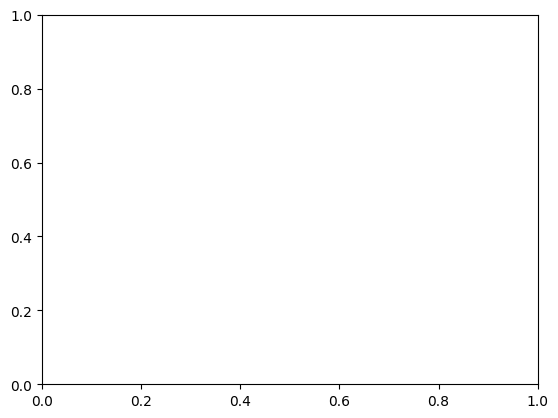

In [24]:
bc_learner = Learner(env, env_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
checkpoint_path = get_checkpoint_path("bc")
reseed(2)
bc_train(
    bc_learner,
    torch.tensor(train_proprios).to(device).float(),
    torch.tensor(train_goals).to(device).float(),
    torch.tensor(train_actions).to(device).float(),
    torch.tensor(validation_proprios).to(device).float(),
    torch.tensor(validation_goals).to(device).float(),
    torch.tensor(validation_actions).to(device).float(),
    checkpoint_path,
    num_epochs = 1500
)

### Evaluate the BC Agent's Performance
**Approximate expected reward for BC learner: -10 to -15**

In [ ]:
bc_learner = Learner(env, env_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
checkpoint_path = get_checkpoint_path("bc")
bc_learner.load_state_dict(torch.load(checkpoint_path))
bc_learner.eval()

print("Avg Reward using Learner Actions = ", (evaluate(env, bc_learner)))
print("Avg Reward using Expert Actions = ", (total_reward))

### Visualize your trained policy!

In [ ]:
class BCTrainedActor():
    def __init__(self, learner):
        self.learner = learner

    def select_action(self, obs):
        return self.learner(
            torch.tensor(obs[ROBOT_PROPRIOCEPTION_KEY], dtype=torch.float, device=device),
            torch.tensor(obs[ROBOT_XYZ_GOAL_KEY], dtype=torch.float, device=device)
        ).detach().cpu().numpy()

bc_trained_actor = BCTrainedActor(bc_learner)

In [ ]:
visualize(env, bc_trained_actor, stop_at_success=True)

## **Hmmm ... 🤔 did the TAs cheat a little in the last visualize block?**

You caught us!

In this `visualize()` call, we stop running the learned policy as soon as it reaches the goal, hence the `stop_at_success=True` argument.

What happens when we don't do this? (run the following block multiple times to see the robot's behavior with different goals)

In [ ]:
visualize(env, bc_trained_actor, stop_at_success=False)

Looks like often, the robot reaches the goal, and then starts moving incorrectly.

**Why does this happen?** Let's think about the data that we used to train our policy: we collected examples of an expert agent moving the robot from its initial state to different goals, given a specified goal as input, and stop collecting data once each time the expert reaches the goal. So, the robot was able to learn decently well how to go from the initial state to a specified goal. But, we never showed any examples of what the robot should do after it reaches the goal, so the trained policy is never guided to output "reasonable" actions after it reaches its goal. We usually would say that this desired behavior is "out of distribution," since it wasn't shown in the training data distribution.

# PART 2: (CS 5756 Only) **Implement and train DAgger Agent**

**Dataset aggregation (DAgger)** is a fundamentally interactive algorithm, where we can query the expert any time we want to get information about how to proceed. This allows for significantly more freedom for the learner, as it can ask the expert anywhere and not be limited by the dataset that it is given to learn from.

**Can we overcome suboptimal actions with DAgger?** Fundamentally, this algorithm allows the learner to recover from bad states and should lead to much better performance than simply behavior cloning a fixed set of expert demonstrations. For this portion of the assignment, you will interact with the environment using the learner policy with random actions. You will do so in **`interact`**.

The DAgger policy will be initialized with the already learned BC policy and your dataset with the already collected expert demonstrations for BC.

Training should take no longer than 2 minutes if implemented correctly.

In [ ]:
def interact(env, learner, expert_network, proprios, goals, actions, validation_proprios, validation_goals, validation_actions, checkpoint_path, seed, num_epochs=100, horizon=50):
    """Interact with the environment and update the learner policy using DAgger.

    This function interacts with the given Gym environment and aggregates to
    the BC dataset by querying the expert.

    Parameters:
        env (Env)
            The gym environment (in this case, the Hopper gym environment)
        learner (Learner)
            A Learner object (policy)
        expert_network (Expert)
            An Expert object (expert policy)
        observations (list of torch.tensor)
            A list of pytorch arrays of shape (N, 10, )
        goals (list of torch.tensor)
            A list of pytorch arrays of shape (N, 3, )
        actions (list of torch.tensor)
            A list of pytorch arrays of shape (N, 4, )
        checkpoint_path (str)
            The path to save the best performing model checkpoint
        seed (int)
            The seed to use for the environment
        num_epochs (int)
            Number of epochs to run the train function for
    """
    # Interact with the environment and aggregate your BC Dataset by querying the expert
    NUM_INTERACTIONS = 9

    best_reward = float('-inf')
    best_model_state = None
    for episode in range(NUM_INTERACTIONS):
        # Aggregate 2 trajectories per interaction
        for _ in range(2):
            done = False
            observation, _ = env.reset(seed = episode)
            for _ in range(horizon):
                # TODO: Implement Fetch Reach environment interaction and dataset aggregation here
                #BEGIN SOLUTION





                #END SOLUTION
                if done:
                    break
        bc_train(learner,
                 torch.tensor(proprios).to(device).float(),
                torch.tensor(goals).to(device).float(),
                torch.tensor(actions).to(device).float(),
                torch.tensor(validation_proprios).to(device).float(),
                torch.tensor(validation_goals).to(device).float(),
                torch.tensor(validation_actions).to(device).float(),
                 "DAgger_Interaction_{}.pth".format(episode), num_epochs)
        reward = evaluate(env, learner)
        print(f"After interaction {episode}, reward = {reward}")
        # Saving model state if current reward is greater than best reward
        if reward > best_reward:
            best_reward = reward
            # Save the best performing checkpoint
            torch.save(learner.state_dict().copy(), checkpoint_path)


**Approximate expected reward for DAgger learner: -4 to -8**

In [ ]:
# Initialize DAgger Agent with BC learner's weights
dagger_learner = Learner(env, env_params)
checkpoint_path = get_checkpoint_path("bc")
dagger_learner.load_state_dict(torch.load(checkpoint_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner.to(device)

In [ ]:
checkpoint_path = get_checkpoint_path("dagger")
seed = 2
reseed(seed)
interact(env, dagger_learner, expert_network, torch.tensor(train_proprios).to(device), torch.tensor(train_goals).to(device), torch.tensor(train_actions).to(device), torch.tensor(validation_proprios).to(device), torch.tensor(validation_goals), torch.tensor(validation_actions).to(device), checkpoint_path, seed, num_epochs = 500)

In [ ]:
dagger_learner = Learner(env, env_params)
checkpoint_path = get_checkpoint_path("dagger")
dagger_learner.load_state_dict(torch.load(checkpoint_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner.to(device)
dagger_learner.eval()

print("Avg Reward using DAgger Learner Actions = ", (evaluate(env, dagger_learner)))
print("Avg Reward using Expert Actions = ", (total_reward))

In [ ]:
class DAggerTrainedActor():
    def __init__(self, learner):
        self.learner = learner
    def select_action(self, obs):
        return self.learner(
            torch.tensor(obs[ROBOT_PROPRIOCEPTION_KEY], dtype=torch.float, device=device),
            torch.tensor(obs[ROBOT_XYZ_GOAL_KEY], dtype=torch.float, device=device)
        ).detach().cpu().numpy()

dagger_trained_actor = DAggerTrainedActor(dagger_learner)

In [ ]:
visualize(env, dagger_trained_actor, stop_at_success=True)